In [1]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Datasets/2payments_rund_10-90.csv', low_memory = False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [23, 21]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [3]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [4]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [5]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [6]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [7]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [8]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [9]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [10]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [11]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [12]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [13]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [15]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 5,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = 0.01,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = 5,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate 
        min_alpha = 0.01,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])
    
    return model

In [16]:
curr_model = training(sentences_series_np_train)

Validation loss decreased (inf --> 54213.386719).  Saving model ...
Validation loss decreased (54213.386719 --> 39329.003906).  Saving model ...
Validation loss decreased (39329.003906 --> 35979.140625).  Saving model ...
Validation loss decreased (35979.140625 --> 33695.640625).  Saving model ...
Validation loss decreased (33695.640625 --> 32051.406250).  Saving model ...
Validation loss decreased (32051.406250 --> 30797.593750).  Saving model ...
Validation loss decreased (30797.593750 --> 29667.546875).  Saving model ...
Validation loss decreased (29667.546875 --> 28544.687500).  Saving model ...
Validation loss decreased (28544.687500 --> 27659.906250).  Saving model ...
Validation loss decreased (27659.906250 --> 26902.093750).  Saving model ...
Validation loss decreased (26902.093750 --> 26100.718750).  Saving model ...
Validation loss decreased (26100.718750 --> 25912.500000).  Saving model ...
Validation loss decreased (25912.500000 --> 25143.125000).  Saving model ...
Validati

In [17]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1, fraud_probv
    
    return 0, nfraud_probv

In [18]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []
    predictions_prob = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction, curr_prob = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)
        predictions_prob.append(curr_prob)

    return predictions, predictions_prob

In [19]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [20]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [21]:
#call predictions
prevs, prevs_prob = predict(curr_model, sentences_series_np_test, verbose1 = True, verbose2 = True)

['nbe', 'pagest', 'c1387461', 'e3', 'r11637226', 'ntrusted', 'io1387462', 'id3', 'binkap', 'nfraud', 'becdar', 'ip85139224225', 'edge', 'windows', 'night', 'w4', 'mon', 'jan', 'pc']
Transaction: [15, 41, 47, 7803, 1, 7804, 0, 46, 2, 60, 7805, 66, 5, 33, 78, 17, 35, 4]
Fraud prob: 0.004823462113563437
Non Fraud prob: 0.004830920581298415
['nbp', 'pagest', 'c4349319', 'e140', 'r5392930', 'ntrusted', 'io1473251', 'id3', 'binkap', 'nfraud', 'ecdarb', 'ip95136110144', 'chrome', 'windows', 'morning', 'w40', 'sat', 'oct', 'pc']
Transaction: [9, 41, 57, 7807, 1, 7808, 0, 46, 2, 53, 7809, 7, 5, 12, 105, 49, 43, 4]
Fraud prob: 0.0023954886273713782
Non Fraud prob: 0.0023977039636520203
['mbp', 'pagtel', 'c1961281', 'e1722582', 'r1961282', 'ntrusted', 'io1961283', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip871035623', 'other', 'android', 'dusk', 'w10', 'tue', 'mar', 'ttablet']
Transaction: [6, 29, 51, 7811, 1, 7812, 0, 24, 2, 28, 7813, 10, 8, 14, 142, 21, 40, 11]
Fraud prob: 0.00458047549091134
Non Fr

Transaction: [9, 3, 118, 7168, 1, 7893, 0, 74, 44, 26, 7894, 7, 8, 33, 106, 23, 36, 22]
Fraud prob: 0.002207765184721211
Non Fraud prob: 0.002178041442675749
['nbp', 'pagest', 'c4932667', 'e140', 'r8664971', 'ntrusted', 'io604119', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip951367072', 'firefox', 'windows', 'afternoon', 'w48', 'thu', 'nov', 'pc']
Transaction: [9, 41, 57, 7896, 1, 7897, 0, 30, 2, 28, 7898, 58, 5, 13, 70, 16, 39, 4]
Fraud prob: 0.0027120227059640456
Non Fraud prob: 0.0027115591346955625
['mbp', 'pagsrv', 'c1885454', 'e932', 'r17651779', 'ntrusted', 'io1885456', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip9462149151', 'safari', 'ios', 'night', 'w20', 'mon', 'may', 'tmobile']
Transaction: [6, 3, 157, 7900, 1, 7901, 0, 30, 2, 28, 7902, 19, 27, 33, 76, 17, 31, 22]
Fraud prob: 0.0022662784613203257
Non Fraud prob: 0.0022944227821426466
['nbp', 'pagsrv', 'c6555428', 'e32880', 'r13724432', 'ntrusted', 'io10395978', 'id3', 'inkapb', 'nfraud', 'darbec', 'ip8215515787', 'safari', 'ios', 'a

Transaction: [6, 3, 161, 7986, 1, 7987, 0, 64, 44, 32, 7988, 19, 27, 14, 89, 25, 40, 22]
Fraud prob: 0.0035788996538030915
Non Fraud prob: 0.003589403844671324
['nbe', 'pagsrv', 'c787037', 'e680', 'r6496699', 'ntrusted', 'io795776', 'id3', 'pbinka', 'nfraud', 'arbecd', 'ip9310822490', 'chrome', 'windows', 'afternoon', 'w43', 'wed', 'oct', 'pc']
Transaction: [15, 3, 159, 7990, 1, 7991, 0, 56, 2, 107, 7992, 7, 5, 13, 100, 23, 43, 4]
Fraud prob: 0.0030525808342645178
Non Fraud prob: 0.0030600063564634183
['mbp', 'pagsrv', 'c3012019', 'e525', 'r15301407', 'ntrusted', 'io3012020', 'id3', 'binkap', 'nfraud', 'darbe', 'ip28191233', 'other', 'android', 'night', 'w14', 'thu', 'apr', 'ttablet']
Transaction: [6, 3, 88, 7994, 1, 7995, 0, 46, 2, 28, 7996, 10, 8, 33, 75, 16, 42, 11]
Fraud prob: 0.0020328933860582765
Non Fraud prob: 0.002035098266787827
['mbp', 'pagsrv', 'c14370199', 'e496', 'r18592905', 'tunknown', 'io14370202', 'id3', 'binkap', 'nfraud', 'cdarbe', 'ip8322322751', 'other', 'android'

Transaction: [6, 3, 86, 8072, 1, 8073, 0, 24, 2, 28, 8074, 10, 8, 13, 78, 49, 35, 11]
Fraud prob: 0.0028595559160748962
Non Fraud prob: 0.0028227167967997957
['mbp', 'pagsrv', 'c2654946', 'e3509', 'r4411793', 'ntrusted', 'io2654948', 'id3', 'nkapi', 'nfraud', 'edarb', 'ip3718919145', 'other', 'android', 'dusk', 'w39', 'mon', 'sep', 'ttablet']
Transaction: [6, 3, 222, 8076, 1, 8077, 0, 24, 2, 63, 8078, 10, 8, 14, 101, 17, 36, 11]
Fraud prob: 0.002844854214345105
Non Fraud prob: 0.0028556114120874554
['nbe', 'pagsrv', 'c1208388', 'e932', 'r15106866', 'ntrusted', 'io96852', 'id3', 'inkapb', 'nfraud', 'cdarbe', 'ip852425979', 'chrome', 'macosx', 'dusk', 'w14', 'tue', 'mar', 'pc']
Transaction: [15, 3, 157, 8080, 1, 8081, 0, 30, 2, 34, 8082, 7, 69, 14, 75, 21, 40, 4]
Fraud prob: 0.002723558558500372
Non Fraud prob: 0.002711434004595503
['nbp', 'apgsrv', 'c3392331', 'e2891', 'r110467', 'trusted', 'io110468', 'id3', 'kapbin', 'nfraud', 'cdarbe', 'ip852442155', 'chrome', 'windows', 'night', 'w4

Transaction: [6, 29, 51, 8165, 50, 8166, 0, 52, 2, 26, 8167, 10, 8, 71, 70, 23, 39, 11]
Fraud prob: 0.0028608438442461193
Non Fraud prob: 0.0028769572199962568
['mbp', 'pagsrv', 'c2745727', 'e1695', 'r2745728', 'ntrusted', 'io1621214', 'id3', 'inkap', 'nfraud', 'arbed', 'ip871036623', 'other', 'android', 'dusk', 'w36', 'thu', 'sep', 'ttablet']
Transaction: [6, 3, 143, 8169, 1, 8170, 0, 20, 2, 26, 8171, 10, 8, 14, 98, 16, 36, 11]
Fraud prob: 0.0019272813860879978
Non Fraud prob: 0.0019288978910481092
['nbp', 'pagsrv', 'c3109065', 'e4219043', 'r16729265', 'ntrusted', 'io9233239', 'id3', 'nkapi', 'nfraud', 'edar', 'ip89115147197', 'chrome', 'windows', 'night', 'w18', 'mon', 'apr', 'pc']
Transaction: [9, 3, 425, 8173, 1, 8174, 0, 24, 2, 93, 8175, 7, 5, 33, 108, 17, 42, 4]
Fraud prob: 0.002881874314880406
Non Fraud prob: 0.002947916086668556
['nbp', 'pagcmp', 'c3176940', 'e398', 'r875199', 'ntrusted', 'io781256', 'id3', 'inkap', 'nfraud', 'darbe', 'ip9592136221', 'safari', 'macosx', 'mornin

Transaction: [6, 3, 148, 8254, 1, 8255, 0, 18, 2, 28, 8256, 10, 8, 13, 103, 45, 43, 11]
Fraud prob: 0.0035354789361008443
Non Fraud prob: 0.0035283616380183958
['mbp', 'pagtel', 'c1733632', 'e1722582', 'r1913752', 'ntrusted', 'io1733634', 'id3', 'apink', 'nfraud', 'cdarbe', 'ip8710358185', 'other', 'android', 'earlymorning', 'w47', 'fri', 'nov', 'ttablet']
Transaction: [6, 29, 51, 8258, 1, 8259, 0, 52, 2, 34, 8260, 10, 8, 71, 77, 25, 39, 11]
Fraud prob: 0.0023821196309654624
Non Fraud prob: 0.00241158819062548
['nbp', 'pagsrv', 'c459456', 'e27601', 'r2497720', 'trusted', 'io459458', 'id3', 'inkap', 'nfraud', 'darbec', 'ip21319021295', 'chrome', 'windows', 'dusk', 'w36', 'tue', 'sep', 'pc']
Transaction: [9, 3, 8262, 8263, 50, 8264, 0, 20, 2, 32, 8265, 7, 5, 14, 98, 21, 36, 4]
Fraud prob: 0.004391416308862972
Non Fraud prob: 0.004419010283527314
['mbp', 'pagsrv', 'c5958600', 'e16751', 'r16203323', 'ntrusted', 'io5958602', 'id3', 'binkap', 'nfraud', 'arbed', 'ip28015029', 'other', 'androi

Transaction: [6, 3, 127, 8337, 1, 8338, 0, 18, 2, 63, 8339, 10, 8, 13, 106, 25, 36, 11]
Fraud prob: 0.0050762350801960565
Non Fraud prob: 0.005050366286013741
['mbp', 'pagsrv', 'c4065504', 'e469', 'r12824398', 'ntrusted', 'io162938', 'id3', 'kapin', 'nfraud', 'bedar', 'ip1767910340', 'other', 'android', 'night', 'w7', 'tue', 'feb', 'ttablet']
Transaction: [6, 3, 59, 8341, 1, 8342, 0, 18, 2, 54, 8343, 10, 8, 33, 114, 21, 48, 11]
Fraud prob: 0.0030706051729794126
Non Fraud prob: 0.0031408904724230524
['mbp', 'pagtel', 'c5697813', 'e1722582', 'r1470991', 'ntrusted', 'io1470969', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip14869194178', 'other', 'android', 'night', 'w13', 'tue', 'mar', 'ttablet']
Transaction: [6, 29, 51, 8345, 1, 8346, 0, 24, 2, 32, 8347, 10, 8, 33, 95, 21, 40, 11]
Fraud prob: 0.0025258901550841983
Non Fraud prob: 0.002547351974499179
['mbp', 'pagsrv', 'c6488024', 'e6464', 'r17585532', 'ntrusted', 'io3820553', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip871036420', 'other', 'android'

Transaction: [6, 29, 51, 8435, 1, 8436, 0, 24, 2, 28, 8437, 10, 8, 55, 142, 17, 40, 11]
Fraud prob: 0.0027646709422697313
Non Fraud prob: 0.0027627664239844307
['mbp', 'pagest', 'c1847833', 'e140', 'r13852013', 'ntrusted', 'io1847835', 'id3', 'inkapb', 'nfraud', 'bedar', 'ip52499362', 'other', 'android', 'earlymorning', 'w10', 'tue', 'mar', 'ttablet']
Transaction: [6, 41, 57, 8439, 1, 8440, 0, 30, 2, 54, 8441, 10, 8, 71, 142, 21, 40, 11]
Fraud prob: 0.0016628487637717626
Non Fraud prob: 0.0016326962931998423
['mbp', 'pagsrv', 'c2104134', 'e1283', 'r13509826', 'ntrusted', 'io2104136', 'id3', 'inkap', 'nfraud', 'rbeda', 'ip4650581', 'other', 'android', 'afternoon', 'w9', 'wed', 'feb', 'ttablet']
Transaction: [6, 3, 196, 8443, 1, 8444, 0, 20, 2, 38, 8445, 10, 8, 13, 102, 23, 48, 11]
Fraud prob: 0.003393786313608871
Non Fraud prob: 0.0034334250613028416
['mbp', 'pagest', 'c4380770', 'e140', 'r16557059', 'ntrusted', 'io372241', 'id3', 'pbinka', 'nfraud', 'becdar', 'ip18882143239', 'safari',

Transaction: [15, 41, 47, 8521, 1, 8522, 0, 149, 2, 34, 8523, 7, 5, 12, 94, 21, 37, 4]
Fraud prob: 0.00293046409933595
Non Fraud prob: 0.002926415574620478
['nbp', 'pagsrv', 'c8357319', 'e3916', 'r8357320', 'ntrusted', 'io4787873', 'id3', 'binkap', 'nfraud', 'darbe', 'ip9460237226', 'chrome', 'windows', 'morning', 'w47', 'sat', 'nov', 'pc']
Transaction: [9, 3, 2545, 8525, 1, 8526, 0, 46, 2, 28, 8527, 7, 5, 12, 77, 49, 39, 4]
Fraud prob: 0.0022706110175931826
Non Fraud prob: 0.0022571817025891505
['nbe', 'pagsrv', 'c4383669', 'e525', 'r9862240', 'ntrusted', 'io4383670', 'id3', 'inkapb', 'nfraud', 'rbeda', 'ip21322151242', 'chrome', 'windows', 'afternoon', 'w51', 'tue', 'dec', 'pc']
Transaction: [15, 3, 88, 8529, 1, 8530, 0, 30, 2, 38, 8531, 7, 5, 13, 91, 21, 37, 4]
Fraud prob: 0.0021704171813325956
Non Fraud prob: 0.002167512557207374
['nbp', 'pagsrv', 'c3975925', 'e2515', 'r4839451', 'ntrusted', 'io471789', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip85247109181', 'chrome', 'windows', 'morni

Transaction: [9, 131, 226, 8616, 1, 8617, 0, 30, 2, 32, 8618, 7, 5, 12, 82, 16, 42, 4]
Fraud prob: 0.004313317522246507
Non Fraud prob: 0.004468987101063249
['mbp', 'pagsrv', 'c4312666', 'e537', 'r5399404', 'ntrusted', 'io4312668', 'id3', 'apink', 'nfraud', 'edar', 'ip1486948228', 'other', 'android', 'afternoon', 'w40', 'sat', 'oct', 'ttablet']
Transaction: [6, 3, 161, 8620, 1, 8621, 0, 52, 2, 93, 8622, 10, 8, 13, 105, 49, 43, 11]
Fraud prob: 0.0032167441031560884
Non Fraud prob: 0.003307219210000767
['mbp', 'pagsrv', 'c4540282', 'e83', 'r9546522', 'ntrusted', 'io4540284', 'id3', 'nkapi', 'nfraud', 'rbeda', 'ip8710319156', 'safari', 'ios', 'dusk', 'w50', 'wed', 'dec', 'tmobile']
Transaction: [6, 3, 68, 8624, 1, 8625, 0, 24, 2, 38, 8626, 19, 27, 14, 94, 23, 37, 22]
Fraud prob: 0.0014129536866676062
Non Fraud prob: 0.0014022345967532601
['nbp', 'pagsrv', 'c12669320', 'e469', 'r14412146', 'ntrusted', 'io555542', 'id3', 'apink', 'fraud', 'negaccount', 'ip1882511290', 'chrome', 'android', '

Transaction: [6, 3, 62, 8700, 1, 8701, 0, 30, 2, 32, 8702, 19, 27, 14, 122, 49, 37, 22]
Fraud prob: 0.002084978430502815
Non Fraud prob: 0.002073761006613495
['mbp', 'pagtel', 'c5226401', 'e1722582', 'r5226402', 'ntrusted', 'io5226403', 'id3', 'inkapb', 'nfraud', 'becdar', 'ip1776325162', 'safari', 'ios', 'dawn', 'w40', 'thu', 'oct', 'tmobile']
Transaction: [6, 29, 51, 8704, 1, 8705, 0, 30, 2, 60, 8706, 19, 27, 55, 105, 16, 43, 22]
Fraud prob: 0.0020536597330647055
Non Fraud prob: 0.0020523048915492836
['nbp', 'pagsrv', 'c3219015', 'e1046', 'r18420033', 'ntrusted', 'io540940', 'id3', 'inkap', 'nfraud', 'rbeda', 'ip94621869', 'chrome', 'macosx', 'morning', 'w21', 'sun', 'may', 'pc']
Transaction: [9, 3, 6194, 8708, 1, 8709, 0, 20, 2, 38, 8710, 7, 69, 12, 80, 45, 31, 4]
Fraud prob: 0.0031664155976613984
Non Fraud prob: 0.0031987703769118525
['nbp', 'pagsrv', 'c5002895', 'e525', 'r16230214', 'trusted', 'io1006639', 'id3', 'inkapb', 'nfraud', 'bedar', 'ip79829187', 'chrome', 'windows', 'dus

Transaction: [15, 41, 47, 8797, 1, 8798, 0, 74, 2, 206, 8799, 99, 5, 12, 90, 17, 31, 4]
Fraud prob: 0.002683929140403052
Non Fraud prob: 0.002689767608899274
['nbe', 'pagest', 'c1551114', 'e3', 'r16126372', 'ntrusted', 'io1551115', 'id3', 'kapbin', 'nfraud', 'becdar', 'ip18881204211', 'chrome', 'windows', 'morning', 'w16', 'fri', 'apr', 'pc']
Transaction: [15, 41, 47, 8801, 1, 8802, 0, 74, 2, 60, 8803, 7, 5, 12, 117, 25, 42, 4]
Fraud prob: 0.002857567906175973
Non Fraud prob: 0.002878566792787751
['mbp', 'pagtel', 'c4014946', 'e1722582', 'r4014947', 'ntrusted', 'io4014948', 'id3', 'kapin', 'nfraud', 'darbec', 'ip8215517544', 'safari', 'ios', 'dawn', 'w45', 'thu', 'nov', 'tmobile']
Transaction: [6, 29, 51, 8805, 1, 8806, 0, 18, 2, 32, 8807, 19, 27, 55, 104, 16, 39, 22]
Fraud prob: 0.0027224017703701975
Non Fraud prob: 0.0026850541926251026
['mbp', 'pagsrv', 'c1725673', 'e469', 'r9458719', 'ntrusted', 'io456276', 'id3', 'pinka', 'nfraud', 'arbed', 'ip16123010671', 'other', 'android', 'af

Transaction: [9, 41, 57, 8892, 1, 8893, 0, 20, 2, 146, 8894, 7, 5, 12, 70, 49, 39, 4]
Fraud prob: 0.0018434131179674296
Non Fraud prob: 0.001848633035478997
['mbp', 'pagtel', 'c4607649', 'e1722582', 'r4836667', 'ntrusted', 'io4607651', 'id3', 'apink', 'nfraud', 'bedar', 'ip9594234229', 'other', 'android', 'night', 'w7', 'mon', 'feb', 'ttablet']
Transaction: [6, 29, 51, 8896, 1, 8897, 0, 52, 2, 54, 8898, 10, 8, 33, 114, 17, 48, 11]
Fraud prob: 0.0021988848675391637
Non Fraud prob: 0.002222201226686593
['nbp', 'pagsrv', 'c11300211', 'e155', 'r11300212', 'ntrusted', 'io4117870', 'id3', 'apbink', 'fraud', 'rbeda', 'ip77111247235', 'chrome', 'windows', 'dusk', 'w3', 'tue', 'jan', 'pc']
Transaction: [9, 3, 134, 8900, 1, 8901, 0, 64, 44, 38, 8902, 7, 5, 14, 110, 21, 35, 4]
Fraud prob: 0.0021571317438429105
Non Fraud prob: 0.0021423291864266503
['mbp', 'pagsrv', 'c9711730', 'e469', 'r12033509', 'ntrusted', 'io268691', 'id3', 'kapin', 'nfraud', 'arbed', 'ip2822046', 'safari', 'ios', 'dawn', 'w5

Transaction: [6, 3, 475, 8989, 1, 8990, 0, 24, 2, 38, 8991, 19, 27, 71, 92, 17, 35, 22]
Fraud prob: 0.0023681785805820255
Non Fraud prob: 0.002365888763961266
['nbp', 'pagsrv', 'c3378756', 'e2201', 'r6900238', 'ntrusted', 'io90277', 'id3', 'inkap', 'nfraud', 'ecdarb', 'ip188836227', 'safari', 'ios', 'afternoon', 'w44', 'wed', 'oct', 'tmobile']
Transaction: [9, 3, 295, 8993, 1, 8994, 0, 20, 2, 53, 8995, 19, 27, 13, 112, 23, 43, 22]
Fraud prob: 0.001927477531353361
Non Fraud prob: 0.0019075898035225691
['nbp', 'pagsrv', 'c4462858', 'e982', 'r12204894', 'ntrusted', 'io482742', 'id3', 'inkap', 'nfraud', 'arbed', 'ip5151144234', 'chrome', 'windows', 'afternoon', 'w5', 'fri', 'jan', 'pc']
Transaction: [9, 3, 155, 8997, 1, 8998, 0, 20, 2, 26, 8999, 7, 5, 13, 85, 25, 35, 4]
Fraud prob: 0.002291732031153515
Non Fraud prob: 0.0022898166826053057
['mbp', 'pagtel', 'c3305667', 'e1366576', 'r3305668', 'ntrusted', 'io3305669', 'id3', 'kapin', 'nfraud', 'cdarbe', 'ip312214957', 'safari', 'ios', 'afte

Transaction: [6, 3, 674, 9072, 1, 9073, 0, 20, 2, 54, 9074, 10, 8, 13, 75, 16, 42, 11]
Fraud prob: 0.0020536774427455384
Non Fraud prob: 0.0020579751617333386
['mbp', 'pagsrv', 'c3547998', 'e66192', 'r3547999', 'ntrusted', 'io3548000', 'id3', 'inkap', 'nfraud', 'rbeda', 'ip193136119249', 'safari', 'ios', 'afternoon', 'w37', 'fri', 'sep', 'tmobile']
Transaction: [6, 3, 9076, 9077, 1, 9078, 0, 20, 2, 38, 9079, 19, 27, 13, 106, 25, 36, 22]
Fraud prob: 0.0022608770905208075
Non Fraud prob: 0.002245810008389526
['nbe', 'pagsrv', 'c9781501', 'e37', 'r9767055', 'ntrusted', 'io383959', 'id3', 'nkapbic', 'fraud', 'rbecda', 'ip93108217110', 'ie', 'windows', 'afternoon', 'w51', 'mon', 'dec', 'pc']
Transaction: [15, 3, 62, 342, 1, 341, 0, 65, 44, 81, 340, 99, 5, 13, 91, 17, 37, 4]
Fraud prob: 0.005191419913794131
Non Fraud prob: 0.00519141991376123
['mbp', 'pagtel', 'c1811783', 'e1723722', 'r1811784', 'ntrusted', 'io1811785', 'id3', 'kapin', 'nfraud', 'arbed', 'ip85244147117', 'other', 'android', 

Transaction: [9, 3, 62, 9160, 1, 9161, 0, 24, 2, 93, 9162, 7, 5, 14, 90, 45, 31, 4]
Fraud prob: 0.001579716493779415
Non Fraud prob: 0.001581517227805307
['nbe', 'pagest', 'c779469', 'e3', 'r9601018', 'ntrusted', 'io352610', 'id3', 'icnkapb', 'nfraud', 'cdarbe', 'ip8524396214', 'safari', 'macosx', 'afternoon', 'w50', 'thu', 'dec', 'pc']
Transaction: [15, 41, 47, 9164, 1, 9165, 0, 199, 2, 34, 9166, 19, 69, 13, 94, 16, 37, 4]
Fraud prob: 0.002062045747152297
Non Fraud prob: 0.002060174974758411
['mbp', 'pagsrv', 'c3781059', 'e525', 'r14695491', 'ntrusted', 'io3781061', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip1781661696', 'other', 'android', 'afternoon', 'w13', 'wed', 'mar', 'ttablet']
Transaction: [6, 3, 88, 9168, 1, 9169, 0, 30, 2, 26, 9170, 10, 8, 13, 95, 23, 40, 11]
Fraud prob: 0.0014887652032484766
Non Fraud prob: 0.0014861057170492131
['nbp', 'pagsrv', 'c3288134', 'e83', 'r674020', 'ntrusted', 'io16168', 'id3', 'inkap', 'nfraud', 'arbed', 'ip14863171241', 'safari', 'macosx', 'morning

Transaction: [15, 131, 159, 9252, 1, 9253, 0, 24, 2, 28, 9254, 7, 5, 13, 76, 21, 31, 4]
Fraud prob: 0.004742297089251224
Non Fraud prob: 0.004720437376818154
['nbp', 'pagcmp', 'c4020657', 'e55', 'r5161640', 'ntrusted', 'io1190077', 'id3', 'binkap', 'nfraud', 'cdarbe', 'ip85244228219', 'chrome', 'windows', 'morning', 'w40', 'wed', 'oct', 'pc']
Transaction: [9, 124, 145, 9256, 1, 9257, 0, 46, 2, 34, 9258, 7, 5, 12, 105, 23, 43, 4]
Fraud prob: 0.005151802703039721
Non Fraud prob: 0.0051671158071258105
['mbp', 'pagsrv', 'c1883955', 'e1258', 'r14902868', 'ntrusted', 'io1883957', 'id3', 'nkapi', 'nfraud', 'edar', 'ip1486339208', 'other', 'android', 'afternoon', 'w13', 'sun', 'mar', 'ttablet']
Transaction: [6, 3, 151, 9260, 1, 9261, 0, 24, 2, 93, 9262, 10, 8, 13, 95, 45, 40, 11]
Fraud prob: 0.0028870314308733214
Non Fraud prob: 0.002876168811781099
['nbp', 'pagest', 'c17806551', 'e140', 'r17806552', 'ntrusted', 'io5214496', 'id3', 'inkap', 'nfraud', 'darbe', 'ip84914089', 'edge', 'windows', '

Transaction: [9, 3, 453, 9348, 1, 9349, 0, 46, 2, 26, 9350, 7, 5, 14, 82, 16, 42, 4]
Fraud prob: 0.0015724378226877889
Non Fraud prob: 0.0015696452483098255
['nbe', 'pagsrv', 'c158494', 'e39097', 'r15890674', 'ntrusted', 'io1334614', 'id3', 'pinka', 'nfraud', 'darbe', 'ip892146978', 'chrome', 'android', 'night', 'w16', 'mon', 'apr', 'ttablet']
Transaction: [15, 3, 336, 9352, 1, 9353, 0, 133, 2, 28, 9354, 7, 8, 33, 117, 17, 42, 11]
Fraud prob: 0.003471083618933335
Non Fraud prob: 0.00347817903093528
['mbp', 'pagsrv', 'c1846342', 'e100', 'r9957348', 'ntrusted', 'io1846344', 'id3', 'kapin', 'nfraud', 'bedar', 'ip1888318199', 'other', 'android', 'dawn', 'w5', 'fri', 'jan', 'ttablet']
Transaction: [6, 3, 127, 9356, 1, 9357, 0, 18, 2, 54, 9358, 10, 8, 55, 85, 25, 35, 11]
Fraud prob: 0.0029816092719556764
Non Fraud prob: 0.002976087009301409
['mbp', 'pagtel', 'c2528705', 'e1722582', 'r738584', 'ntrusted', 'io436318', 'id3', 'kapin', 'nfraud', 'darbe', 'ip1486912130', 'safari', 'ios', 'afterno

Transaction: [9, 41, 57, 9437, 1, 9438, 0, 56, 2, 53, 9439, 7, 5, 33, 76, 16, 31, 4]
Fraud prob: 0.002400404089712538
Non Fraud prob: 0.0023785490629961714
['nbp', 'pagtel', 'c3111553', 'e151', 'r8556427', 'ntrusted', 'io674206', 'id3', 'kapin', 'nfraud', 'bedar', 'ip85245958', 'firefox', 'windows', 'morning', 'w48', 'wed', 'nov', 'pc']
Transaction: [9, 29, 165, 9441, 1, 9442, 0, 18, 2, 54, 9443, 58, 5, 12, 70, 23, 39, 4]
Fraud prob: 0.0024297389172716066
Non Fraud prob: 0.0024234710435848683
['mbp', 'pagsrv', 'c1734994', 'e21288', 'r7689776', 'ntrusted', 'io1734996', 'id3', 'pinka', 'nfraud', 'bedar', 'ip2133020122', 'other', 'android', 'afternoon', 'w46', 'tue', 'nov', 'ttablet']
Transaction: [6, 3, 9445, 9446, 1, 9447, 0, 133, 2, 54, 9448, 10, 8, 13, 121, 21, 39, 11]
Fraud prob: 0.0053954274735588115
Non Fraud prob: 0.005458323077618843
['mbp', 'pagsrv', 'c1928395', 'e217', 'r4891420', 'ntrusted', 'io413181', 'id3', 'kapin', 'nfraud', 'edar', 'ip8710319133', 'other', 'android', 'dus

Transaction: [6, 29, 51, 9536, 1, 9537, 0, 18, 2, 38, 9538, 19, 27, 12, 76, 21, 31, 22]
Fraud prob: 0.0022464943322120234
Non Fraud prob: 0.0022544529965671245
['mbp', 'pagsrv', 'c1860654', 'e4683', 'r15001477', 'ntrusted', 'io1860656', 'id3', 'nkapi', 'nfraud', 'ecdarb', 'ip89180233193', 'other', 'android', 'night', 'w14', 'mon', 'mar', 'ttablet']
Transaction: [6, 3, 451, 9540, 1, 9541, 0, 24, 2, 53, 9542, 10, 8, 33, 75, 17, 40, 11]
Fraud prob: 0.0034039166785078123
Non Fraud prob: 0.003403359150979668
['nbp', 'pagtel', 'c3600119', 'e41', 'r65410', 'ntrusted', 'io65395', 'id3', 'apink', 'nfraud', 'negaccount', 'ip8524610310', 'chrome', 'windows', 'morning', 'w8', 'sat', 'feb', 'pc']
Transaction: [9, 29, 125, 9544, 1, 9545, 0, 52, 2, 87, 9546, 7, 5, 12, 120, 49, 48, 4]
Fraud prob: 0.0025596260511520086
Non Fraud prob: 0.002576648241301882
['mbp', 'pagtel', 'c2195201', 'e1722582', 'r2195202', 'ntrusted', 'io2195203', 'id3', 'apink', 'nfraud', 'rbeda', 'ip89180159229', 'safari', 'ios', '

Transaction: [6, 29, 51, 9633, 1, 9634, 0, 18, 2, 146, 9635, 10, 8, 55, 91, 23, 37, 11]
Fraud prob: 0.002203643305620062
Non Fraud prob: 0.0021840466197318165
['nbp', 'pagsrv', 'c5032201', 'e525', 'r17865618', 'ntrusted', 'io794493', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip941334881', 'edge', 'windows', 'dusk', 'w20', 'thu', 'may', 'pc']
Transaction: [9, 3, 88, 9637, 1, 9638, 0, 30, 2, 28, 9639, 66, 5, 14, 76, 16, 31, 4]
Fraud prob: 0.001597429364665004
Non Fraud prob: 0.001593846768628282
['mbp', 'pagsrv', 'c1913399', 'e30505', 'r17856220', 'ntrusted', 'io1913401', 'id3', 'kapin', 'nfraud', 'cdarbe', 'ip312220367', 'safari', 'ios', 'dusk', 'w20', 'thu', 'may', 'tmobile']
Transaction: [6, 3, 3945, 9641, 1, 9642, 0, 18, 2, 34, 9643, 19, 27, 14, 76, 16, 31, 22]
Fraud prob: 0.004224245312798303
Non Fraud prob: 0.004251005120750051
['nbp', 'apgsrv', 'c3595621', 'e29693', 'r5407517', 'trusted', 'io460049', 'id3', 'nkapi', 'nfraud', 'ecdarb', 'ip10949156221', 'safari', 'macosx', 'dusk', 'w40'

Transaction: [6, 3, 1064, 9725, 1, 9726, 0, 18, 2, 34, 9727, 19, 27, 12, 120, 45, 48, 22]
Fraud prob: 0.0022999589091341477
Non Fraud prob: 0.0022925367920834105
['mbp', 'pagtel', 'c2580521', 'e1722582', 'r2580522', 'ntrusted', 'io2580523', 'id3', 'kapin', 'nfraud', 'darbe', 'ip28355189', 'other', 'android', 'dusk', 'w43', 'thu', 'oct', 'ttablet']
Transaction: [6, 29, 51, 9729, 1, 9730, 0, 18, 2, 28, 9731, 10, 8, 14, 100, 16, 43, 11]
Fraud prob: 0.0031513104695477523
Non Fraud prob: 0.0031697795566287823
['mbp', 'pagsrv', 'c2533397', 'e1695', 'r11645269', 'ntrusted', 'io1805078', 'id3', 'nkapi', 'nfraud', 'rbeda', 'ip82154114211', 'other', 'android', 'earlymorning', 'w4', 'tue', 'jan', 'ttablet']
Transaction: [6, 3, 143, 9733, 1, 9734, 0, 24, 2, 38, 9735, 10, 8, 71, 78, 21, 35, 11]
Fraud prob: 0.0015119265954126604
Non Fraud prob: 0.001476484008890111
['nbp', 'pagsrv', 'c381930', 'e398', 'r381931', 'ntrusted', 'io381932', 'id3', 'inkap', 'nfraud', 'darbec', 'ip6228112114', 'chrome', 'w

Transaction: [15, 3, 6619, 9816, 1, 9817, 0, 30, 2, 53, 9818, 99, 5, 12, 102, 16, 48, 4]
Fraud prob: 0.001686119432633859
Non Fraud prob: 0.0016838641404319787
['nbe', 'pagsrv', 'c813714', 'e7243', 'r11451799', 'ntrusted', 'io813715', 'id3', 'inkapb', 'nfraud', 'arbecdd', 'ip89154427', 'safari', 'ios', 'morning', 'w3', 'fri', 'jan', 'ttablet']
Transaction: [15, 3, 119, 9820, 1, 9821, 0, 30, 2, 140, 9822, 19, 27, 12, 110, 25, 35, 11]
Fraud prob: 0.0018170346456827247
Non Fraud prob: 0.001805778528250812
['mbp', 'pagsrv', 'c7114539', 'e525', 'r10782355', 'ntrusted', 'io461368', 'id3', 'inkap', 'nfraud', 'darbec', 'ip7754217171', 'other', 'android', 'morning', 'w1', 'sun', 'jan', 'ttablet']
Transaction: [6, 3, 88, 9824, 1, 9825, 0, 20, 2, 32, 9826, 10, 8, 12, 84, 45, 35, 11]
Fraud prob: 0.0017829503540269798
Non Fraud prob: 0.0017603265205252683
['mbp', 'pagsrv', 'c11799253', 'e7590', 'r13944444', 'ntrusted', 'io2843388', 'id3', 'binkap', 'nfraud', 'rbeda', 'ip8322323396', 'safari', 'ios'

Transaction: [6, 3, 68, 9909, 1, 9910, 0, 24, 2, 32, 9911, 10, 8, 12, 104, 23, 39, 11]
Fraud prob: 0.0015546468757747789
Non Fraud prob: 0.0015380972226921585
['nbp', 'pagsrv', 'c3112808', 'e83', 'r11025639', 'ntrusted', 'io40724', 'id3', 'nkapi', 'nfraud', 'rbeda', 'ip371892293', 'chrome', 'windows', 'morning', 'w2', 'thu', 'jan', 'pc']
Transaction: [9, 3, 68, 9913, 1, 9914, 0, 24, 2, 38, 9915, 7, 5, 12, 92, 16, 35, 4]
Fraud prob: 0.002768132406345103
Non Fraud prob: 0.002757357229711488
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14077757', 'ntrusted', 'io555542', 'id3', 'kapin', 'fraud', 'arbed', 'ip1882511290', 'other', 'android', 'dusk', 'w11', 'thu', 'mar', 'ttablet']
Transaction: [6, 3, 59, 9916, 1, 147, 0, 18, 44, 26, 160, 10, 8, 14, 79, 16, 40, 11]
Fraud prob: 0.009468127242448856
Non Fraud prob: 0.009468127242448526
['mbp', 'pagsrv', 'c3451182', 'e939', 'r4451585', 'ntrusted', 'io3451183', 'id3', 'nkapi', 'nfraud', 'edarb', 'ip8710368157', 'safari', 'ios', 'morning', 'w39', 'tue'

Transaction: [15, 41, 47, 10001, 1, 10002, 0, 65, 2, 107, 10003, 58, 5, 14, 117, 16, 42, 4]
Fraud prob: 0.0021869151660212083
Non Fraud prob: 0.0022221159870241536
['nbe', 'pagsrv', 'c2822611', 'e1691', 'r2829857', 'ntrusted', 'io2822612', 'id3', 'pbinka', 'fraud', 'darbec', 'ip9593227136', 'edge', 'windows', 'afternoon', 'w36', 'fri', 'sep', 'pc']
Transaction: [15, 3, 207, 5304, 1, 249, 0, 56, 44, 32, 215, 66, 5, 13, 98, 25, 36, 4]
Fraud prob: 0.00014958459729976843
Non Fraud prob: 0.00014958459729977802
['mbp', 'pagsrv', 'c2862864', 'e1332', 'r5820400', 'ntrusted', 'io2862865', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip82154217115', 'other', 'android', 'night', 'w41', 'fri', 'oct', 'ttablet']
Transaction: [6, 3, 202, 10005, 1, 10006, 0, 24, 2, 26, 10007, 10, 8, 33, 130, 25, 43, 11]
Fraud prob: 0.0037708385025325697
Non Fraud prob: 0.003740146548807388
['nbp', 'pagsrv', 'c3299469', 'e613', 'r13532970', 'ntrusted', 'io592631', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip1486923910', 'chrome', '

Transaction: [15, 41, 47, 10088, 1, 10089, 0, 30, 2, 34, 10090, 7, 5, 14, 103, 25, 43, 4]
Fraud prob: 0.0024790890456642956
Non Fraud prob: 0.0024950375664047897
['mbp', 'pagsrv', 'c9692008', 'e29235', 'r16412251', 'ntrusted', 'io2751082', 'id3', 'nkapi', 'nfraud', 'rbecda', 'ip176786114', 'safari', 'ios', 'night', 'w17', 'tue', 'apr', 'tmobile']
Transaction: [6, 3, 1283, 10092, 1, 10093, 0, 24, 2, 81, 10094, 19, 27, 33, 82, 21, 42, 22]
Fraud prob: 0.0014637097765444196
Non Fraud prob: 0.001463045974560373
['nbp', 'pagsrv', 'c4910417', 'e15954', 'r13446172', 'ntrusted', 'io7042035', 'id3', 'inkap', 'nfraud', 'darbe', 'ip94607987', 'chrome', 'windows', 'dusk', 'w9', 'mon', 'feb', 'pc']
Transaction: [9, 3, 10096, 10097, 1, 10098, 0, 20, 2, 28, 10099, 7, 5, 14, 102, 17, 48, 4]
Fraud prob: 0.0017684592930891085
Non Fraud prob: 0.0017779941663320642
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14081176', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'arbed', 'ip1882511290', 'other', 'android'

Transaction: [15, 3, 88, 10179, 1, 10180, 0, 30, 2, 34, 10181, 7, 5, 14, 90, 25, 31, 4]
Fraud prob: 0.002666245407453971
Non Fraud prob: 0.002689752702281112
['nbp', 'pagcmp', 'c3094270', 'e469', 'r12671093', 'ntrusted', 'io541035', 'id3', 'inkap', 'nfraud', 'edarb', 'ip8184236229', 'edge', 'windows', 'night', 'w6', 'sat', 'feb', 'pc']
Transaction: [9, 124, 59, 10183, 1, 10184, 0, 20, 2, 63, 10185, 66, 5, 33, 96, 49, 48, 4]
Fraud prob: 0.0031776838441146538
Non Fraud prob: 0.0031562270742142573
['mbp', 'pagsrv', 'c15695142', 'e83', 'r17207068', 'ntrusted', 'io1818112', 'id3', 'inkap', 'nfraud', 'rbeda', 'ip89152111202', 'other', 'android', 'morning', 'w19', 'tue', 'may', 'ttablet']
Transaction: [6, 3, 68, 10187, 1, 10188, 0, 20, 2, 38, 10189, 10, 8, 12, 90, 21, 31, 11]
Fraud prob: 0.0022394089319277555
Non Fraud prob: 0.0022813885589130223
['mbp', 'pagsrv', 'c4645848', 'e107', 'r5578021', 'ntrusted', 'io4645849', 'id3', 'apink', 'nfraud', 'rbeda', 'ip8815788221', 'safari', 'ios', 'afte

Transaction: [139, 3, 10273, 10274, 1, 10275, 0, 24, 2, 28, 138, 19, 27, 13, 73, 21, 36, 22]
Fraud prob: 0.0029128481655789074
Non Fraud prob: 0.0029510237036447506
['nbe', 'pagsrv', 'c1067522', 'e5623', 'r7867627', 'ntrusted', 'io1067523', 'id3', 'kapbin', 'fraud', 'darbec', 'ip85247162167', 'chrome', 'windows', 'afternoon', 'w51', 'thu', 'dec', 'pc']
Transaction: [15, 3, 118, 209, 1, 262, 0, 74, 44, 32, 266, 7, 5, 13, 91, 16, 37, 4]
Fraud prob: 0.003423447922399879
Non Fraud prob: 0.0034234479223803644
['nbp', 'pagest', 'c4646373', 'e140', 'r14613820', 'ntrusted', 'io206967', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip891096529', 'edge', 'windows', 'afternoon', 'w13', 'tue', 'mar', 'pc']
Transaction: [9, 41, 57, 10277, 1, 10278, 0, 24, 2, 32, 10279, 66, 5, 13, 95, 21, 40, 4]
Fraud prob: 0.001611749601579504
Non Fraud prob: 0.0016184725573111791
['nbe', 'pagsrv', 'c310473', 'e791', 'r18701611', 'ntrusted', 'io310475', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip16123037216', 'chrome', 'windows

Transaction: [6, 29, 51, 10367, 1, 10368, 0, 18, 2, 38, 10369, 10, 8, 12, 117, 21, 42, 11]
Fraud prob: 0.00145667486867751
Non Fraud prob: 0.001457342576031806
['mbe', 'pagest', 'c12382133', 'e3', 'r17851860', 'ntrusted', 'io12382134', 'id3', 'inkapb', 'nfraud', 'darbe', 'ipunknown', 'other', 'android', 'afternoon', 'w20', 'thu', 'may', 'ttablet']
Transaction: [139, 41, 47, 10371, 1, 10372, 0, 30, 2, 28, 138, 10, 8, 13, 76, 16, 31, 11]
Fraud prob: 0.0018547934660091414
Non Fraud prob: 0.0018548483376434888
['nbp', 'pagtel', 'c4857960', 'e322', 'r486294', 'trusted', 'io184354', 'id3', 'nkapi', 'nfraud', 'dare', 'ip2805190', 'safari', 'ios', 'night', 'w45', 'mon', 'nov', 'tmobile']
Transaction: [9, 29, 187, 10374, 50, 10375, 0, 24, 2, 137, 10376, 19, 27, 33, 104, 17, 39, 22]
Fraud prob: 0.002121648916727281
Non Fraud prob: 0.002112898115228745
['mbp', 'pagsrv', 'c3663563', 'e4776350', 'r7217670', 'ntrusted', 'io2293248', 'id3', 'inkap', 'nfraud', 'cdarbe', 'ip41188126102', 'other', 'andr

Transaction: [15, 41, 47, 10453, 1, 10454, 0, 46, 2, 53, 10455, 7, 5, 13, 110, 16, 35, 4]
Fraud prob: 0.00242461984998954
Non Fraud prob: 0.0024236710069089895
['nbp', 'pagsrv', 'c3126713', 'e932', 'r10217568', 'ntrusted', 'io213672', 'id3', 'nkapi', 'nfraud', 'negaccount', 'ip941338233', 'chrome', 'windows', 'afternoon', 'w52', 'mon', 'dec', 'pc']
Transaction: [9, 3, 157, 10457, 1, 10458, 0, 24, 2, 87, 10459, 7, 5, 13, 122, 17, 37, 4]
Fraud prob: 0.001987127303436864
Non Fraud prob: 0.0019472960993880406
['nbp', 'pagtel', 'c3473917', 'e151', 'r17716774', 'ntrusted', 'io7208505', 'id3', 'nkapi', 'nfraud', 'negaccount', 'ip82155105160', 'chrome', 'windows', 'dusk', 'w20', 'tue', 'may', 'pc']
Transaction: [9, 29, 165, 10461, 1, 10462, 0, 24, 2, 87, 10463, 7, 5, 14, 76, 21, 31, 4]
Fraud prob: 0.0019518204353516921
Non Fraud prob: 0.001956519394298084
['nbp', 'pagsrv', 'c3336207', 'e5623', 'r9234785', 'ntrusted', 'io87127', 'id3', 'kapbin', 'fraud', 'darbe', 'ip54339208', 'chrome', 'window

Transaction: [9, 131, 68, 10541, 1, 10542, 0, 20, 2, 87, 10543, 7, 5, 14, 79, 25, 40, 4]
Fraud prob: 0.003653050669527147
Non Fraud prob: 0.0036755504333996214
['mbp', 'pagtel', 'c8364215', 'e1723722', 'r8364216', 'ntrusted', 'io8364217', 'id3', 'kapin', 'nfraud', 'darbec', 'ip8719680161', 'safari', 'ios', 'earlymorning', 'w21', 'sat', 'may', 'tmobile']
Transaction: [6, 29, 153, 10545, 1, 10546, 0, 18, 2, 32, 10547, 19, 27, 71, 80, 49, 31, 22]
Fraud prob: 0.001961842682248971
Non Fraud prob: 0.0019795820635408745
['mbp', 'pagsrv', 'c3221561', 'e79', 'r3221562', 'trusted', 'io2449760', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip85246177173', 'safari', 'ios', 'afternoon', 'w14', 'tue', 'mar', 'tmobile']
Transaction: [6, 3, 67, 10549, 50, 10550, 0, 30, 2, 26, 10551, 19, 27, 13, 75, 21, 40, 22]
Fraud prob: 0.006508299396955408
Non Fraud prob: 0.006531951075885445
['nbp', 'pagsrv', 'c3445005', 'e155', 'r6068063', 'ntrusted', 'io411827', 'id3', 'nkapbic', 'fraud', 'cdarbe', 'ip8918111712', 'chro

Transaction: [6, 3, 59, 10637, 1, 10638, 0, 24, 2, 38, 10639, 19, 27, 13, 97, 45, 36, 22]
Fraud prob: 0.003088827736064559
Non Fraud prob: 0.0030893169714545365
['nbp', 'pagtel', 'c3524811', 'e2463', 'r430549', 'ntrusted', 'io217536', 'id3', 'kapin', 'nfraud', 'bedar', 'ip8918124647', 'chrome', 'android', 'earlymorning', 'w1', 'tue', 'dec', 'ttablet']
Transaction: [9, 29, 6547, 10641, 1, 10642, 0, 18, 2, 54, 10643, 7, 8, 71, 84, 21, 37, 11]
Fraud prob: 0.0016310883838741574
Non Fraud prob: 0.0016292562631861074
['nbp', 'pagsrv', 'c3557704', 'e469', 'r8813922', 'ntrusted', 'io52787', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip891531927', 'chrome', 'windows', 'dusk', 'w48', 'fri', 'nov', 'pc']
Transaction: [9, 3, 59, 10645, 1, 10646, 0, 24, 2, 28, 10647, 7, 5, 14, 70, 25, 39, 4]
Fraud prob: 0.0014674365729661076
Non Fraud prob: 0.0014428144995690673
['mbp', 'pagsrv', 'c2076263', 'e100', 'r4445739', 'ntrusted', 'io2076265', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip1486936210', 'other', 'android',

Transaction: [9, 3, 2435, 10724, 1, 10725, 0, 52, 2, 54, 10726, 7, 5, 13, 98, 23, 36, 4]
Fraud prob: 0.0028694179782178253
Non Fraud prob: 0.0028720796617562883
['mbp', 'pagsrv', 'c2134293', 'e398', 'r2134294', 'ntrusted', 'io2134295', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip9460580', 'other', 'android', 'night', 'w9', 'sat', 'feb', 'ttablet']
Transaction: [6, 3, 116, 10728, 1, 10729, 0, 24, 2, 28, 10730, 10, 8, 33, 102, 49, 48, 11]
Fraud prob: 0.0034142281801905483
Non Fraud prob: 0.003445835754973814
['mbp', 'pagsrv', 'c14424205', 'e79', 'r15047435', 'ntrusted', 'io14424207', 'id3', 'inkap', 'nfraud', 'arbed', 'ip95936216', 'other', 'android', 'afternoon', 'w14', 'tue', 'mar', 'ttablet']
Transaction: [6, 3, 67, 10732, 1, 10733, 0, 20, 2, 26, 10734, 10, 8, 13, 75, 21, 40, 11]
Fraud prob: 0.001720256230328232
Non Fraud prob: 0.0017167591249744873
['mbp', 'pagsrv', 'c2507440', 'e9338', 'r3078188', 'ntrusted', 'io2507442', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip9463405', 'other', 'android'

Transaction: [6, 29, 51, 10812, 1, 10813, 0, 52, 2, 26, 10814, 10, 8, 12, 78, 25, 35, 11]
Fraud prob: 0.0016780786427261773
Non Fraud prob: 0.0016724985216569621
['mbp', 'pagtel', 'c3576988', 'e1722582', 'r1413893', 'trusted', 'io240502', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip148695885', 'other', 'android', 'dusk', 'w37', 'fri', 'sep', 'ttablet']
Transaction: [6, 29, 51, 10816, 50, 10817, 0, 24, 2, 32, 10818, 10, 8, 14, 106, 25, 36, 11]
Fraud prob: 0.0013932399997429457
Non Fraud prob: 0.0013946967155789025
['nbe', 'pagsrv', 'c1130923', 'e4192', 'r12171511', 'ntrusted', 'io1130925', 'id3', 'pbinka', 'nfraud', 'darbec', 'ip9593138167', 'chrome', 'windows', 'earlymorning', 'w5', 'fri', 'jan', 'pc']
Transaction: [15, 3, 10820, 10821, 1, 10822, 0, 56, 2, 32, 10823, 7, 5, 71, 85, 25, 35, 4]
Fraud prob: 0.002779075861326419
Non Fraud prob: 0.002782953204587102
['nbe', 'atfsep', 'c1146521', 'e3', 'r3', 'ntrusted', 'io1146522', 'id14705091', 'inkapb', 'nfraud', 'cdarbe', 'ip1094821171', 'chro

Transaction: [6, 29, 153, 10901, 1, 10902, 0, 24, 2, 60, 10903, 10, 8, 12, 82, 25, 42, 11]
Fraud prob: 0.0029783891877741553
Non Fraud prob: 0.002974430604808731
['mbp', 'pagsrv', 'c1898620', 'e1258', 'r6249063', 'ntrusted', 'io520351', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip82155100123', 'safari', 'ios', 'morning', 'w42', 'sat', 'oct', 'tmobile']
Transaction: [6, 3, 151, 10905, 1, 10906, 0, 24, 2, 32, 10907, 19, 27, 12, 103, 49, 43, 22]
Fraud prob: 0.0037154014771658694
Non Fraud prob: 0.0037479996917682
['mbp', 'pagsrv', 'c1946266', 'e20910', 'r16737190', 'ntrusted', 'io1946267', 'id3', 'inkapb', 'nfraud', 'edarb', 'ip951361083', 'other', 'android', 'morning', 'w18', 'tue', 'apr', 'ttablet']
Transaction: [6, 3, 10909, 10910, 1, 10911, 0, 30, 2, 63, 10912, 10, 8, 12, 108, 21, 42, 11]
Fraud prob: 0.002458822724292986
Non Fraud prob: 0.0024953805550467223
['nbp', 'pagsrv', 'c5258325', 'e5775', 'r7828847', 'ntrusted', 'io476997', 'id3', 'pbinka', 'nfraud', 'cdarbe', 'ip8513962115', 'othe

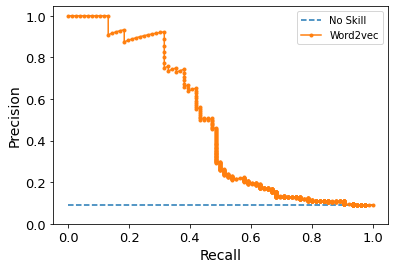

In [27]:
#precision-recall curve - compute precision-recall pairs for different probability thresholds
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, prevs_prob)

no_skill = y_test.count(1) / len(y_test)

#no-skill classifier
pyplot.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

#word2vec classifier
pyplot.plot(recall, precision, marker = '.', label = 'Word2vec')

#labels
pyplot.xlabel('Recall', fontsize = 14)
pyplot.ylabel('Precision', fontsize = 14)

#ticks
pyplot.yticks(fontsize = 13)
pyplot.yticks(np.arange(0.0, 1.2, 0.2))
pyplot.xticks(fontsize = 13)

#legend
pyplot.legend()

#save
plt.savefig(r'C:\Users\BeatrizCarvalho\OneDrive - Closer Consultoria Lda\Documents\Entangled-Spaces\Payments\Notebooks\After loss correction\imbalanced_pr-curve\prcurve.png')

pyplot.show()